In [1]:
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
import pickle as pkl
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
from sklearn import linear_model

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Average, Bidirectional, TimeDistributed, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))

# Data Creation

In [8]:
df = pd.read_excel("data_processed.xlsx", sheet_name=0, header=0)

indexes = np.unique(df['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [df['Study_Subject_Number'].values[index] for index in sorted(indexes)]

In [9]:
len(patient_list)

466

In [10]:
lengths = []
male = []
ages = []
for p in patient_list:
    lengths.append(len(df[df['Study_Subject_Number'] == p]))
    if df['Sex_M'][df['Study_Subject_Number'] == p].values[0]==0:
        male.append(1)
    ages.append(df['Age (yrs)'][df['Study_Subject_Number'] == p].values[0])
print('Average Age:', np.mean(ages))
print('Male:', np.sum(male))
print('Male Percentage:', np.sum(male)/len(patient_list))
print('Average Checkup Months:', np.mean(lengths) + 1 + 1) # order 1 + order -1

Average Age: 58.33047210300429
Male: 218
Male Percentage: 0.4678111587982833
Average Checkup Months: 34.63948497854077


In [11]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order'] 

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [12]:
df = df[all_vars]

In [13]:
def data_generation(data, patient_list, seq_len, trn_scaler=None, trg_scaler=None):

    # EPO Requirement:
#     data[data['EPO_Dose'] > 800] = np.nan

    seq_set = []
    patient_set = []
    
    for p in tqdm(patient_list):
        record_len = len(data[data['Study_Subject_Number'] == p])
        for i in range(seq_len, record_len+1):
            if i<= record_len:
                seq_idx = data[data['Study_Subject_Number'] == p].index[i-seq_len:i].values
                seq_order = data['Order'][data['Study_Subject_Number'] == p].iloc[i-seq_len:i].values

                seq_set.append(seq_idx)
                patient_set.append(seq_order)
                
    if trn_scaler:
        data_matrix = trn_scaler.transform(data[trn_vars])
    else:
        data_matrix = data[trn_vars].values
        
    if trg_scaler:
        label = trg_scaler.transform(data[target_var])
    else:
        label = data[target_var].values

    x_data = np.array([data_matrix[seq] for seq in seq_set])
    y_data = np.array([label[seq][-1] for seq in seq_set])
    patient_set = np.array(patient_set)
    
    return x_data, y_data, patient_set

In [14]:
seqences_we_want = [1,2,3,4,5,6]
seed = 0

# Pure Data

In [15]:
pure_to_be_saved = pd.DataFrame()
patient_list_wo_na = []
for p in patient_list:
    temp = df[df['Study_Subject_Number']==p]
    if sum(temp.isnull().sum())==0:
        patient_list_wo_na.append(p)
        pure_to_be_saved = pd.concat([pure_to_be_saved, temp])
df_pure = pure_to_be_saved[all_vars]
df_pure.index = range(len(df_pure))
df_pure.to_excel("Anemia_Pure.xlsx", index=False)

In [16]:
len(patient_list_wo_na)

120

In [17]:
train_patient_pure, test_patient_pure = train_test_split(patient_list_wo_na, test_size = 0.2, random_state=seed)
valid_patient_pure, test_patient_pure = train_test_split(test_patient_pure, test_size = 0.5, random_state=seed)

In [18]:
print('Train:', len(train_patient_pure))
print('Valid:', len(valid_patient_pure))
print('Test:', len(test_patient_pure))

Train: 96
Valid: 12
Test: 12


In [19]:
# Train: 96
# Valid: 12
# Test: 12

In [16]:
trn_idx = []
for p in train_patient_pure:
    trn_idx.extend(df_pure[df_pure['Study_Subject_Number']==p].index.values)

In [17]:
trn_scaler_pure = StandardScaler().fit(df_pure[trn_vars].iloc[trn_idx])
with open('./trn_scaler_pure.pkl','wb') as f:
    pkl.dump(trn_scaler_pure, f)

hb_scaler_pure = StandardScaler().fit(df_pure[target_var].iloc[trn_idx])
with open('./hb_scaler_pure.pkl','wb') as f:
    pkl.dump(hb_scaler_pure, f)

In [20]:
for seq_len in seqences_we_want:
    
    x_train, y_train, order_train_pure = data_generation(df_pure, train_patient_pure, seq_len, trn_scaler_pure, hb_scaler_pure)
    x_valid, y_valid, order_valid_pure = data_generation(df_pure, valid_patient_pure, seq_len, trn_scaler_pure, hb_scaler_pure)
    x_test, y_test, order_test_pure = data_generation(df_pure, test_patient_pure, seq_len, trn_scaler_pure, hb_scaler_pure)
    
    print('Seq Len:', seq_len, '|', len(order_train_pure), len(order_valid_pure), len(order_test_pure))
    print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))2
    
    with open('./pure_'+str(seq_len)+'.pkl','wb') as f:
        pkl.dump([[x_train,y_train, order_train_pure],[x_valid,y_valid, order_valid_pure],[x_test,y_test, order_test_pure]], f)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.60it/s]


Seq Len: 1 | 2368 219 283
9.301868584697257e-17 0.017281919290929926 0.01493576105165286


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.25it/s]


Seq Len: 2 | 2272 207 271
0.0007659564440369387 0.018328002714300844 0.018329672066615326


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 39.19it/s]


Seq Len: 3 | 2176 195 259
0.001590874369509591 0.019906847920066462 0.023533836857312668


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.79it/s]


Seq Len: 4 | 2082 183 247
0.002390150113281361 0.020741667908637695 0.02894917110376476


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 42.07it/s]


Seq Len: 5 | 1989 171 235
0.003320819170022947 0.021749585945788144 0.0345555127165408


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 44.73it/s]


Seq Len: 6 | 1903 160 224
0.003944150217521296 0.022370321036016015 0.03805214288573672


# Mean Imputation

In [20]:
df_mean = df.copy()

In [21]:
start = time.time()
variable_mean = df_mean.mean()
for p in patient_list:
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(method='ffill') # fill all below
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(method='bfill') # fill all above
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(value = variable_mean) # fill with mean if none exists
print(time.time()-start) # 15.924424648284912

df_mean[all_vars].to_excel("Anemia_MEAN.xlsx", index=False)

16.346404552459717


In [22]:
train_patient_mean, test_patient_mean = train_test_split(patient_list, test_size = 0.2, random_state=seed)
valid_patient_mean, test_patient_mean = train_test_split(test_patient_mean, test_size = 0.5, random_state=seed)

In [23]:
print('Train:', len(train_patient_mean))
print('Valid:', len(valid_patient_mean))
print('Test:', len(test_patient_mean))

Train: 372
Valid: 47
Test: 47


In [24]:
# Train: 372
# Valid: 47
# Test: 47

In [25]:
plt.rcParams["figure.figsize"] = (10,5)

In [40]:
# data_for_trajectory = pd.DataFrame()
# for p in train_patient_mean+valid_patient_mean+test_patient_mean:
#     temp = pd.DataFrame(data={'Study_Subject_Number': df_mean['Study_Subject_Number'][df_mean['Study_Subject_Number']==p].values, 'Hb': df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, 'index':list(range(len(df_mean[df_mean['Study_Subject_Number']==p].values)))})
#     data_for_trajectory = pd.concat([data_for_trajectory, temp], axis=0)
# data_for_trajectory.to_excel('./trajectory_analysis_data/all_data.xlsx', index=False)

# data_for_trajectory = pd.DataFrame()
# for p in train_patient_mean:
#     temp = pd.DataFrame(data={'Study_Subject_Number': df_mean['Study_Subject_Number'][df_mean['Study_Subject_Number']==p].values, 'Hb': df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, 'index':list(range(len(df_mean[df_mean['Study_Subject_Number']==p].values)))})
#     data_for_trajectory = pd.concat([data_for_trajectory, temp], axis=0)
# data_for_trajectory.to_excel('./trajectory_analysis_data/train_data.xlsx', index=False)

# data_for_trajectory = pd.DataFrame()
# for p in valid_patient_mean:
#     temp = pd.DataFrame(data={'Study_Subject_Number': df_mean['Study_Subject_Number'][df_mean['Study_Subject_Number']==p].values, 'Hb': df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, 'index':list(range(len(df_mean[df_mean['Study_Subject_Number']==p].values)))})
#     data_for_trajectory = pd.concat([data_for_trajectory, temp], axis=0)
# data_for_trajectory.to_excel('./trajectory_analysis_data/valid_data.xlsx', index=False)

# data_for_trajectory = pd.DataFrame()
# for p in test_patient_mean:
#     temp = pd.DataFrame(data={'Study_Subject_Number': df_mean['Study_Subject_Number'][df_mean['Study_Subject_Number']==p].values, 'Hb': df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, 'index':list(range(len(df_mean[df_mean['Study_Subject_Number']==p].values)))})
#     data_for_trajectory = pd.concat([data_for_trajectory, temp], axis=0)
# data_for_trajectory.to_excel('./trajectory_analysis_data/test_data.xlsx', index=False)

In [165]:
plt.rcParams["figure.figsize"] = (15,8)

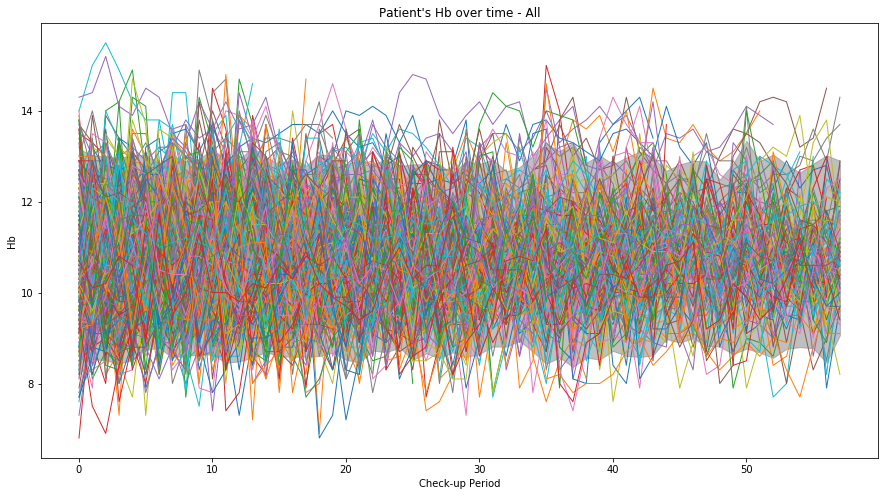

In [175]:
patientss = train_patient_mean+valid_patient_mean+test_patient_mean
hbs = []
for p in patientss:
    hb = df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values.tolist()
    hbs.append(hb + [np.nan]*(58-len(hb)))
for p in patientss:
    plt.plot(df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, alpha=1, linewidth=1)
plt.fill_between(list(range(58)), 
                 np.nanmean(hbs,axis=0) - 1.9600 * np.nanstd(hbs,axis=0), 
                 np.nanmean(hbs,axis=0) + 1.9600 * np.nanstd(hbs,axis=0),
                 alpha=0.5, color='gray', label='95% confidence interval')
plt.title("Patient's Hb over time - All")
plt.xlabel('Check-up Period')
plt.ylabel('Hb')
plt.savefig('all.png')
plt.show()

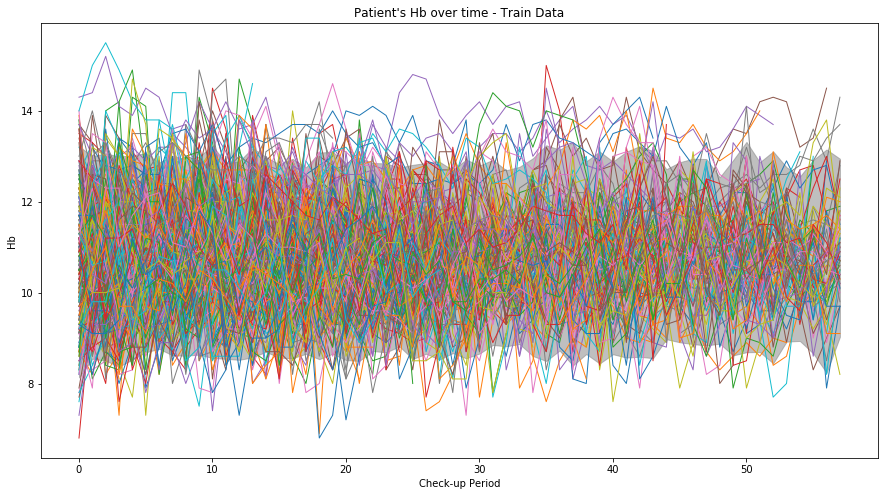

In [176]:
patientss = train_patient_mean
hbs = []
for p in patientss:
    hb = df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values.tolist()
    hbs.append(hb + [np.nan]*(58-len(hb)))
for p in patientss:
    plt.plot(df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, alpha=1, linewidth=1)
plt.fill_between(list(range(58)), 
                 np.nanmean(hbs,axis=0) - 1.9600 * np.nanstd(hbs,axis=0), 
                 np.nanmean(hbs,axis=0) + 1.9600 * np.nanstd(hbs,axis=0),
                 alpha=0.5, color='gray', label='95% confidence interval')
plt.title("Patient's Hb over time - Train Data")
plt.xlabel('Check-up Period')
plt.ylabel('Hb')
plt.savefig('train.png')
plt.show()

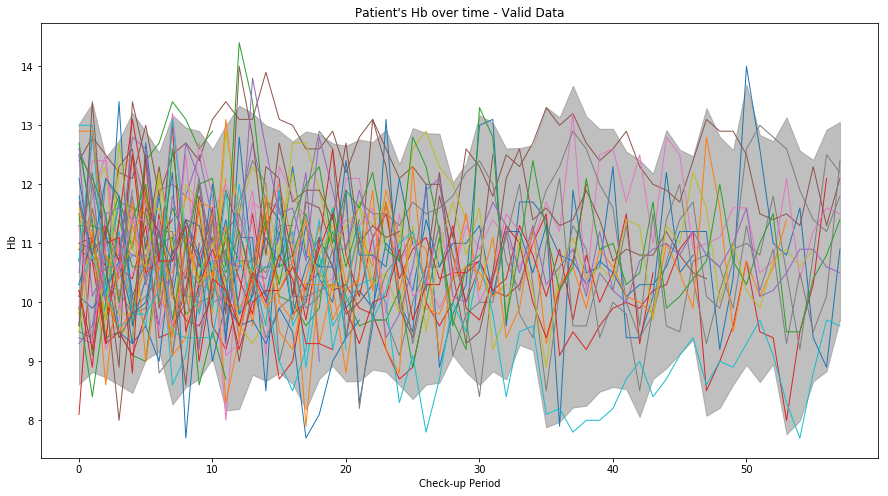

In [177]:
patientss = valid_patient_mean
hbs = []
for p in patientss:
    hb = df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values.tolist()
    hbs.append(hb + [np.nan]*(58-len(hb)))
for p in patientss:
    plt.plot(df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, alpha=1, linewidth=1)
plt.fill_between(list(range(58)), 
                 np.nanmean(hbs,axis=0) - 1.9600 * np.nanstd(hbs,axis=0), 
                 np.nanmean(hbs,axis=0) + 1.9600 * np.nanstd(hbs,axis=0),
                 alpha=0.5, color='gray', label='95% confidence interval')
plt.title("Patient's Hb over time - Valid Data")
plt.xlabel('Check-up Period')
plt.ylabel('Hb')
plt.savefig('valid.png')
plt.show()

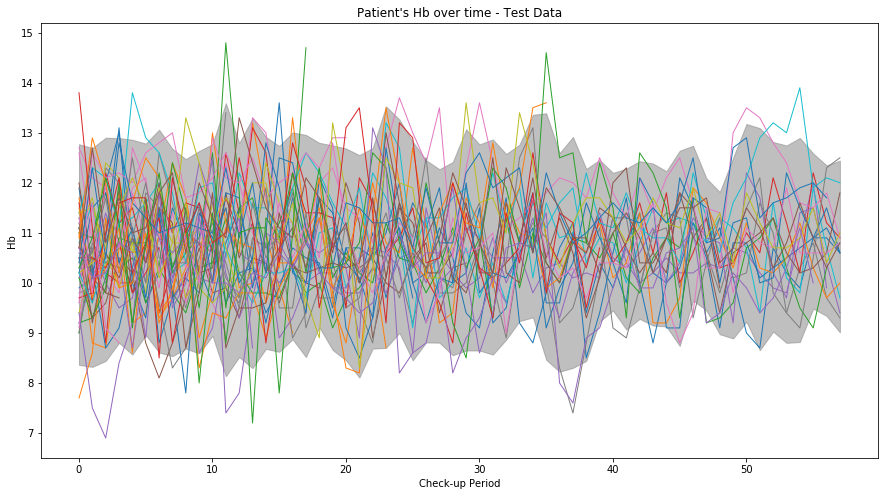

In [178]:
patientss = test_patient_mean
hbs = []
for p in patientss:
    hb = df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values.tolist()
    hbs.append(hb + [np.nan]*(58-len(hb)))
for p in patientss:
    plt.plot(df_mean['Hemoglobin[Whole blood]'][df_mean['Study_Subject_Number']==p].values, alpha=1, linewidth=1)
plt.fill_between(list(range(58)), 
                 np.nanmean(hbs,axis=0) - 1.9600 * np.nanstd(hbs,axis=0), 
                 np.nanmean(hbs,axis=0) + 1.9600 * np.nanstd(hbs,axis=0),
                 alpha=0.5, color='gray', label='95% confidence interval')
plt.title("Patient's Hb over time - Test Data")
plt.xlabel('Check-up Period')
plt.ylabel('Hb')
plt.savefig('test.png')
plt.show()

# DAE Imputation

In [9]:
max_checkup = max([len(df[df['Study_Subject_Number']==p]) for p in patient_list])
max_checkup

58

In [10]:
max_checkup = 100

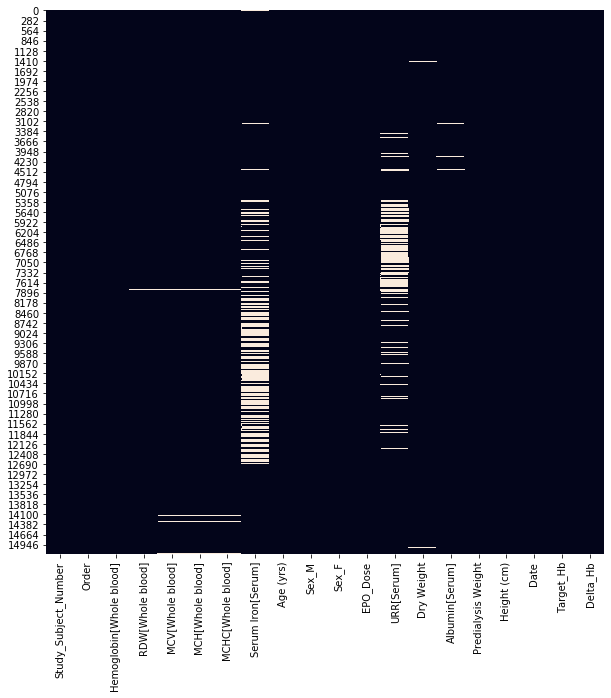

In [11]:
plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(df.isnull(), cbar=False, xticklabels=df.columns.values)

In [12]:
df[trn_vars].isnull().sum()

Hemoglobin[Whole blood]       0
Delta_Hb                      0
RDW[Whole blood]             52
MCV[Whole blood]            114
MCH[Whole blood]            114
MCHC[Whole blood]           114
Serum Iron[Serum]          3787
Age (yrs)                     0
Sex_M                         0
Sex_F                         0
EPO_Dose                      0
URR[Serum]                 2430
Dry Weight                   47
Albumin[Serum]               46
Predialysis Weight            4
Height (cm)                   0
dtype: int64

In [13]:
sr = df[trn_vars].isnull().sum()/len(df)
sr*100

Hemoglobin[Whole blood]     0.000000
Delta_Hb                    0.000000
RDW[Whole blood]            0.341880
MCV[Whole blood]            0.749507
MCH[Whole blood]            0.749507
MCHC[Whole blood]           0.749507
Serum Iron[Serum]          24.898093
Age (yrs)                   0.000000
Sex_M                       0.000000
Sex_F                       0.000000
EPO_Dose                    0.000000
URR[Serum]                 15.976331
Dry Weight                  0.309007
Albumin[Serum]              0.302433
Predialysis Weight          0.026298
Height (cm)                 0.000000
dtype: float64

In [14]:
mask_prob = {}
for i, v in zip(sr.index, sr.values):
    mask_prob[i] = v 

In [15]:
mm = MinMaxScaler().fit(pure_to_be_saved[trn_vars])

seq = []
seq_length = []
for p in patient_list_wo_na:
    temp = pure_to_be_saved[trn_vars][pure_to_be_saved['Study_Subject_Number']==p]
    seq_length.append(len(temp))    
    diff = max_checkup - len(temp)
    temp = np.concatenate([mm.transform(temp), np.zeros((diff,len(trn_vars)))], axis=0)
    seq.append(temp)
seq = np.array(seq)
seq_length = np.array(seq_length)

In [16]:
train_idx, valid_idx = train_test_split(range(len(seq)), test_size = 0.2, random_state=seed)
# valid_idx, test_idx = train_test_split(valid_idx, test_size = 0.5, random_state=seed)

In [17]:
print(len(train_idx),len(valid_idx)) # 76 10 10

96 24


In [18]:
class DataGenerator(Sequence):
    def __init__(self, data, seq_length, mask_prob, batch_size = 4, noisy=False, shuffle=True, set_seed=False):
        
        if set_seed:
            np.random.seed(0)
        
        self.data = data        
        self.data_noisy = None
        self.seq_length = seq_length
        
        self.index = [i for i in range(self.data.shape[0])]
        self.batch_size = batch_size
        self.noisy = noisy
        self.mask_prob = mask_prob    
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        x, y = [], []
        for i in range(index, index+self.batch_size):
            x.append(self.data_noisy[self.index[i]].tolist())
            y.append(self.data[self.index[i]].tolist())
        return np.array(x), np.array(y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.index)
            
        self.data_noisy = self.data.copy()

        if self.noisy:            
            for i, (d, idx) in enumerate(zip(self.data, self.seq_length)):
                mask = np.random.uniform(size=d.shape)<[list(self.mask_prob.values())]*idx+np.zeros((d.shape[0]-idx,d.shape[1])).tolist()
                self.data_noisy[i][mask]=-1

In [19]:
learning_rate = 0.0005
batch_size = 2
activation_func = 'relu'
imputation_cell_size = 128
epochs = 300

In [20]:
train_gen = DataGenerator(seq[train_idx], seq_length[train_idx], mask_prob, batch_size=batch_size, noisy=True)
valid_gen = DataGenerator(seq[valid_idx], seq_length[valid_idx], mask_prob, batch_size=batch_size, noisy=True)
# test_gen = DataGenerator(seq[test_idx], seq_length[test_idx], mask_prob, batch_size=batch_size, noisy=True)

In [21]:
dropout_rate = 0.1

In [22]:
input_shape = len(trn_vars)

In [23]:
def DAE():
    
    K.clear_session()
    
    inp = Input(shape=(max_checkup, input_shape))

    encoded = Bidirectional(CuDNNLSTM(imputation_cell_size, return_sequences=True))(inp)
    encoded = Dropout(dropout_rate)(encoded)
    decoded = Bidirectional(CuDNNLSTM(imputation_cell_size, return_sequences=True))(encoded)
    decoded = Dropout(dropout_rate)(decoded)
    
    oupt = TimeDistributed(Dense(input_shape, activation=activation_func))(decoded)

    autoencoder = Model(inp, oupt)

    autoencoder.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    return autoencoder

autoencoder = DAE()

checkpoint = ModelCheckpoint('./DAE_'+str(imputation_cell_size)+'_0.1.h5', save_best_only=True, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [24]:
history = autoencoder.fit_generator(generator=train_gen,
                                validation_data=valid_gen,
                                callbacks=[checkpoint],
                                epochs=epochs, verbose=0)

Instructions for updating:
Use tf.cast instead.
12/12 [==============================] - 0s 20ms/step - loss: 0.0061

Epoch 00001: val_loss improved from inf to 0.00606, saving model to ./DAE_128_0.1.h5
12/12 [==============================] - 0s 9ms/step - loss: 0.0043

Epoch 00002: val_loss improved from 0.00606 to 0.00432, saving model to ./DAE_128_0.1.h5
12/12 [==============================] - 0s 9ms/step - loss: 0.0037

Epoch 00003: val_loss improved from 0.00432 to 0.00371, saving model to ./DAE_128_0.1.h5
12/12 [==============================] - 0s 11ms/step - loss: 0.0031

Epoch 00004: val_loss improved from 0.00371 to 0.00311, saving model to ./DAE_128_0.1.h5
12/12 [==============================] - 0s 9ms/step - loss: 0.0028

Epoch 00005: val_loss improved from 0.00311 to 0.00284, saving model to ./DAE_128_0.1.h5
12/12 [==============================] - 0s 11ms/step - loss: 0.0028

Epoch 00006: val_loss improved from 0.00284 to 0.00284, saving model to ./DAE_128_0.1.h5
12/12

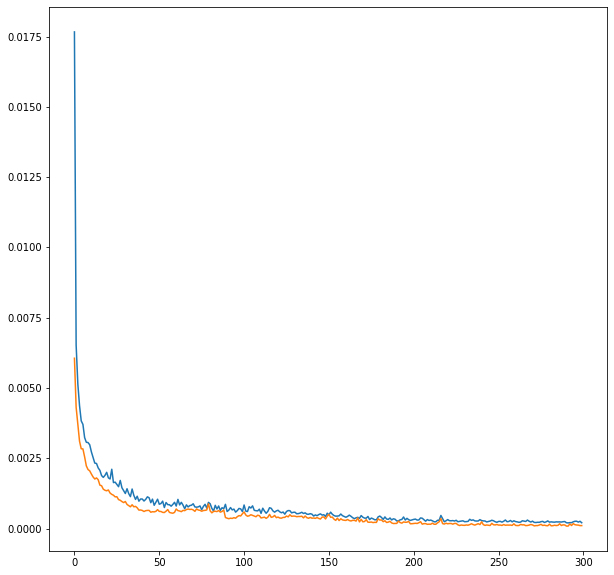

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [27]:
autoencoder.load_weights('./DAE_'+str(imputation_cell_size)+'_0.1.h5')
print(autoencoder.evaluate_generator(generator=train_gen))
print(autoencoder.evaluate_generator(generator=valid_gen))
# print(autoencoder.evaluate_generator(generator=test_gen))

9.775054328050221e-05
8.957645847355404e-05


In [28]:
0.00016819939446577337
0.00012977179540030193

0.00012977179540030193

In [29]:
print('DAE_'+str(imputation_cell_size)+'_0.1.h5')

DAE_128_0.1.h5


In [30]:
new = df[all_vars].copy()
empty_mask = np.invert(new[trn_vars].isnull().values)

In [31]:
start = time.time()
for p in patient_list:
    new[new['Study_Subject_Number']==p] = new[new['Study_Subject_Number']==p].fillna(value = -1) # fill with -1 if none exists
print(time.time()-start)

4.444114446640015


In [32]:
seq = []
seq_length = []
for p in patient_list:
    temp = new[trn_vars][new['Study_Subject_Number']==p]
    seq_length.append(len(temp))
    diff = max_checkup - len(temp)
    temp = np.concatenate([mm.transform(temp), np.zeros((diff,len(trn_vars)))], axis=0)
    seq.append(temp)
seq = np.array(seq)
seq_length = np.array(seq_length)

In [33]:
imputed = autoencoder.predict(seq)
imputed_data = []
for d, s in zip(imputed, seq_length):
    imputed_data.extend(mm.inverse_transform(d)[:s].round(2))
imputed_data = np.array(imputed_data)

In [34]:
imputed_data[empty_mask] = new[trn_vars].values[empty_mask]

In [35]:
others = new[target_var+info_vars].values

df_imputed = pd.DataFrame(np.concatenate([others, imputed_data],axis=1), columns=target_var+info_vars+trn_vars)

In [36]:
df_imputed = df_imputed[new.columns.values]

In [37]:
df[all_vars].tail()

,Study_Subject_Number,Order,Hemoglobin[Whole blood],Delta_Hb,RDW[Whole blood],MCV[Whole blood],MCH[Whole blood],MCHC[Whole blood],Serum Iron[Serum],Age (yrs),Sex_M,Sex_F,EPO_Dose,URR[Serum],Dry Weight,Albumin[Serum],Predialysis Weight,Height (cm),Target_Hb
15205,A-202,A-202_07,11.5,0.0,12.3,94.6,31.1,32.9,71.0,65,1,0,0.0,73.552124,54.8,3.8,56.2,164.8,10.7
15206,A-203,A-203_02,11.0,2.2,14.5,92.2,30.6,33.1,55.0,67,0,1,40.0,71.776156,61.3,3.2,62.3,158.0,10.9
15207,A-203,A-203_03,10.9,0.1,13.4,89.7,30.4,33.9,66.0,67,0,1,220.0,70.862069,61.3,3.6,62.9,158.0,11.8
15208,A-203,A-203_04,11.8,0.9,14.7,NaN,NaN,NaN,55.0,67,0,1,40.0,63.396226,61.3,3.6,63.4,158.0,10.8
15209,A-203,A-203_05,10.8,1.0,14.3,88.3,30.1,34.1,43.0,67,0,1,80.0,77.717391,60.8,3.7,63.9,158.0,9.2


In [38]:
df_imputed.tail()

,Study_Subject_Number,Order,Hemoglobin[Whole blood],Delta_Hb,RDW[Whole blood],MCV[Whole blood],MCH[Whole blood],MCHC[Whole blood],Serum Iron[Serum],Age (yrs),Sex_M,Sex_F,EPO_Dose,URR[Serum],Dry Weight,Albumin[Serum],Predialysis Weight,Height (cm),Target_Hb
15205,A-202,A-202_07,11.5,0,12.3,94.6,31.1,32.9,71,65,1,0,0,73.5521,54.8,3.8,56.2,164.8,10.7
15206,A-203,A-203_02,11,2.2,14.5,92.2,30.6,33.1,55,67,0,1,40,71.7762,61.3,3.2,62.3,158,10.9
15207,A-203,A-203_03,10.9,0.1,13.4,89.7,30.4,33.9,66,67,0,1,220,70.8621,61.3,3.6,62.9,158,11.8
15208,A-203,A-203_04,11.8,0.9,14.7,90.94,29.95,33.09,55,67,0,1,40,63.3962,61.3,3.6,63.4,158,10.8
15209,A-203,A-203_05,10.8,1,14.3,88.3,30.1,34.1,43,67,0,1,80,77.7174,60.8,3.7,63.9,158,9.2


In [39]:
df_imputed[all_vars].to_excel("Anemia_DAE.xlsx", index=False)

In [40]:
train_patient_dae, test_patient_dae = train_test_split(patient_list, test_size = 0.2, random_state=seed)
valid_patient_dae, test_patient_dae = train_test_split(test_patient_dae, test_size = 0.5, random_state=seed)

In [41]:
trn_idx = []
for p in train_patient_dae:
    trn_idx.extend(df_imputed[df_imputed['Study_Subject_Number']==p].index.values)

In [42]:
trn_scaler_dae = StandardScaler().fit(df_imputed[trn_vars].iloc[trn_idx])
with open('./trn_scaler_dae.pkl','wb') as f:
    pkl.dump(trn_scaler_dae, f)

hb_scaler_dae = StandardScaler().fit(df_imputed[target_var].iloc[trn_idx])
with open('./hb_scaler_dae.pkl','wb') as f:
    pkl.dump(hb_scaler_dae, f)

In [43]:
for seq_len in seqences_we_want:
    
    x_train, y_train, order_train_dae = data_generation(df_imputed, train_patient_dae, seq_len, trn_scaler_dae, hb_scaler_dae)
    x_valid, y_valid, order_valid_dae = data_generation(df_imputed, valid_patient_dae, seq_len, trn_scaler_dae, hb_scaler_dae)
    x_test, y_test, order_test_dae = data_generation(df_imputed, test_patient_dae, seq_len, trn_scaler_dae, hb_scaler_dae)  
    print('Seq Len:', seq_len, '|', len(order_train_dae), len(order_valid_dae), len(order_test_dae))
    print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))

    with open('./dae_'+str(seq_len)+'.pkl','wb') as f:
        pkl.dump([[x_train,y_train, order_train_dae],[x_valid,y_valid, order_valid_dae],[x_test,y_test, order_test_dae]], f)

100%|██████████████████████████████████| 47/47 [00:03<00:00, 12.67it/s]


Seq Len: 1 | 12169 1420 1621
-6.247684503766187e-17 -0.01737135575771291 -0.048150112988955704


100%|██████████████████████████████████| 47/47 [00:03<00:00, 12.95it/s]


Seq Len: 2 | 11797 1373 1574
0.0006369347626616881 -0.016060966761175858 -0.047110846413269854


100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.46it/s]


Seq Len: 3 | 11425 1326 1528
0.0014945012861852004 -0.014267243742480652 -0.045998842142531415


100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.86it/s]


Seq Len: 4 | 11054 1280 1482
0.0022121234022892747 -0.013075432710940865 -0.04529375821738135


100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.33it/s]


Seq Len: 5 | 10684 1234 1437
0.00283646821071157 -0.012136646702136739 -0.04455791477612897


100%|██████████████████████████████████| 47/47 [00:03<00:00, 14.68it/s]


Seq Len: 6 | 10324 1188 1395
0.003274464914657362 -0.011511870287215594 -0.04396483769545488
